In [2]:
import os
import numpy as np
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
tf.__version__

'2.4.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [5]:
DIR = 'images'
VAL_DIR = 'validation'
data_dir = pathlib.Path(DIR)

IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 36

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:
def format_image(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=format_image)

train_batches = image_generator.flow_from_directory(directory=str(DIR),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     classes=list(CLASS_NAMES))


validation_batches = image_generator.flow_from_directory(directory=str(VAL_DIR),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     classes=list(CLASS_NAMES))



Found 1299 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


In [8]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(((image_batch[n] + 1) * 127.5).astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

(32, 160, 160, 3)

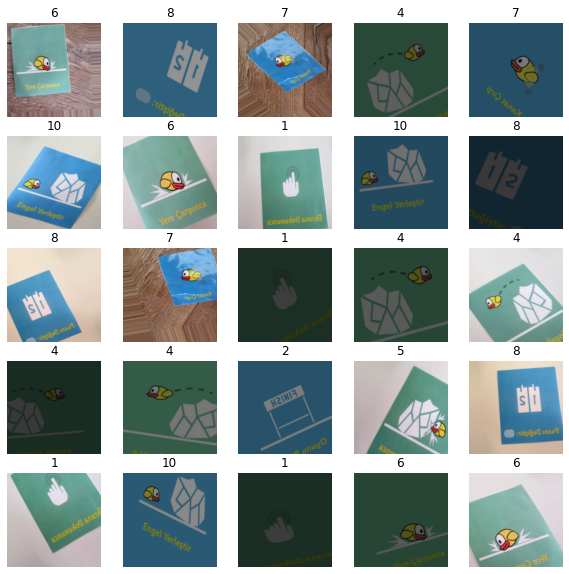

In [9]:
image_batch, label_batch = next(train_batches)
show_batch(image_batch, label_batch)
image_batch.shape

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [27]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
len(model.trainable_variables)

2

In [29]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

20/20 [==============================] - 2s 38ms/step - loss: 2.6056 - accuracy: 0.1320
initial loss: 2.63
initial accuracy: 0.13
Epoch 1/10
41/41 [==============================] - 5s 78ms/step - loss: 2.2368 - accuracy: 0.2079 - val_loss: 1.9521 - val_accuracy: 0.2950
Epoch 2/10
41/41 [==============================] - 3s 75ms/step - loss: 1.7908 - accuracy: 0.4034 - val_loss: 1.6056 - val_accuracy: 0.5350
Epoch 3/10
41/41 [==============================] - 3s 76ms/step - loss: 1.4637 - accuracy: 0.5974 - val_loss: 1.3219 - val_accuracy: 0.6700
Epoch 4/10
41/41 [==============================] - 3s 75ms/step - loss: 1.2013 - accuracy: 0.7460 - val_loss: 1.0932 - val_accuracy: 0.7900
Epoch 5/10
41/41 [==============================] - 3s 74ms/step - loss: 0.9904 - accuracy: 0.8314 - val_loss: 0.9092 - val_accuracy: 0.8575
Epoch 6/10
41/41 [==============================] - 3s 74ms/step - loss: 0.8209 - accuracy: 0.8938 - val_loss: 0.7610 - val_accuracy: 0.9050
Epoch 7/10
41/41 [======

Text(0.5, 1.0, 'Training and Validation Accuracy')

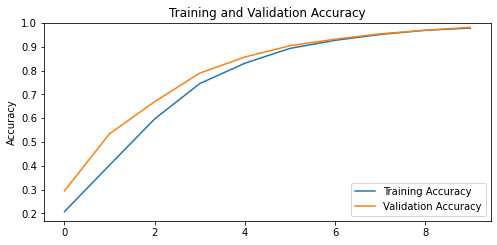

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

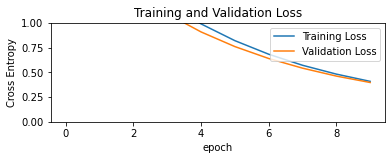

In [31]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
!mkdir -p saved_model
model.save('saved_model/flappy_model')

INFO:tensorflow:Assets written to: saved_model/flappy_model/assets


In [33]:
#or save it as h5 format
model.save('flappy_model.h5')

In [38]:
# use it in tensorflow js
!mkdir -p tfjs_model
!tensorflowjs_converter --input_format keras flappy_model.h5 tfjs_model

2021-02-13 18:47:53.214704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
